# Homework 12 for PUI2016
**Name:** Cheng Hou

**NetID:** ch3019

---

In [1]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
from fiona.crs import from_epsg
import pandas as pd
import numpy as np
import os
from matplotlib.pylab import plt

%matplotlib inline

if os.getenv("PUIDATA") is None:
    print ("error: $PUIDATA env variable does not exist!")
else:
    puidata = os.getenv("PUIDATA")
    if not os.path.exists(puidata):
        os.system("mkdir " + puidata)
    print ("$PUIDATA: {}".format(puidata))

$PUIDATA: /home/cusp/ch3019/PUIdata


---
## 1. Define the function to download the data with an SQL query.
It is provided by fedhere from [here](https://github.com/fedhere/PUI2016_fb55/blob/master/HW12_fb55/Assignment%201%20instructions.ipynb). 

In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

---
## 2. Query the facilities Data
The name of the DB is **NYCAsthmasDismissals**.

within the SQLquery group the data by zipcode.

In [3]:
facilityQuery = '''
SELECT zipcodes, count(*) as count
FROM NYCAsthmasDismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
facilities = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


---
## 3. Find the shape file with zipcode shapes for NYC and Read it
Download NYC zip codes shape file from [fedhere's github repo](https://github.com/fedhere/PUI2016_fb55/blob/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson).

In [4]:
def getNYCzipcode(filename='nyc-zip-code-tabulation-areas-polygons.geojson',
                  url='https://raw.githubusercontent.com/fedhere/PUI2016_fb55/\
                  master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson'):
    if not os.path.isfile(puidata + '/' + filename):
        if not os.path.isfile(filename):
            if os.system("wget " + url) != 0:
                print ("error: Cannot download file : {}".format(filename))
                return 1
        print ("Moves geojson file to {}".format(puidata))
        os.system("mv " + filename + " " + puidata)
    
    # Add to getNYCzipcode Attributes
    getNYCzipcode.filename = puidata + '/' + filename
    getNYCzipcode.url = url    
    print ("Complete.")
    return 0

In [5]:
getNYCzipcode()
ZCfilename = getNYCzipcode.filename

Complete.


In [6]:
zipNYC = gpd.read_file(ZCfilename)
zipNYC.rename(columns={'postalCode': "zipcodes"}, inplace=True)
zipNYC.crs = from_epsg(4326)
zipNYC = zipNYC.to_crs(epsg=2263)
zipNYC['centers'] = zipNYC.geometry.centroid
zipNYC = zipNYC.loc[:, ['zipcodes', 'centers']]
zipNYC.zipcodes = pd.to_numeric(zipNYC.zipcodes)
zipNYC.head()

,zipcodes,centers
0,11372,POINT (1016507.91923967 213149.4526626311)
1,11004,POINT (1064161.614534125 210966.8623252437)
2,11040,POINT (1066417.467739376 212198.6524612)
3,11426,POINT (1060736.757623353 207736.4239017649)
4,11365,POINT (1041165.498508966 208910.1072870745)


## 4. Merge the data

In [7]:
Merge = gpd.GeoDataFrame(pd.merge(facilities, zipNYC, on='zipcodes'))
Merge

,count,zipcodes,centers
0,1699,10461,POINT (1028293.521922282 247902.5491998894)
1,405,11373,POINT (1017940.176803979 208484.2631296574)
2,1698,10451,POINT (1005358.679665448 238318.1400382799)
3,220,11691,POINT (1050362.334509322 158232.1726125965)
4,246,11375,POINT (1026860.707186352 201881.500496663)
5,494,10466,POINT (1026643.707424621 263909.2278427444)
6,713,11212,POINT (1008368.584586044 180771.4352490225)
7,167,11229,POINT (999710.1689214484 158289.9342567111)
8,521,11215,POINT (989852.537199228 181771.6023145769)
9,386,11220,POINT (979606.1023132938 172876.2179307172)


## 5. Plot

In [8]:
Mergeplot = Merge.loc[:,['count']]
Mergeplot['lon'] = Merge.centers.apply(lambda p: p.x)
Mergeplot['la'] = Merge.centers.apply(lambda p: p.y)

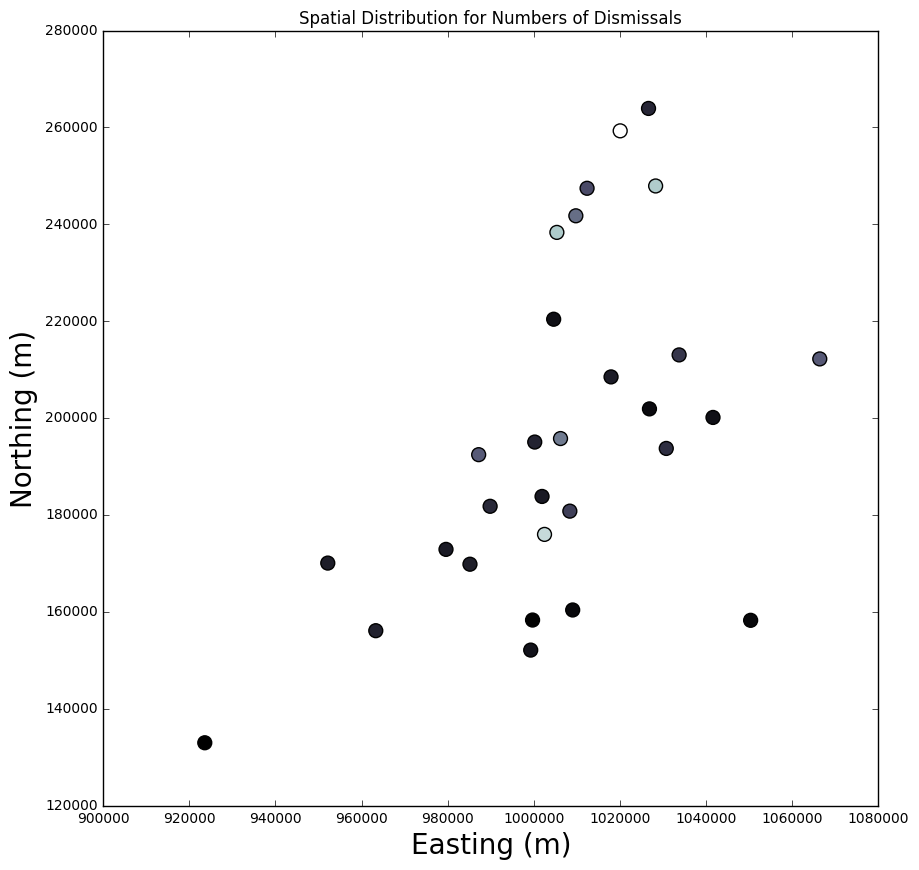

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(Mergeplot.lon, Mergeplot.la, c=Mergeplot['count'], s=100, cmap=plt.cm.bone)
plt.xlabel("Easting (m)", fontsize=20)
plt.ylabel("Northing (m)", fontsize=20)
plt.title('Spatial Distribution for Numbers of Dismissals')
plt.show()